#### **Training data**

This representation of label has an impact on the learning set up. Now we have :
* A feature matrix $\mathbf X$ of shape $(n, m)$ wher $n$ is the number of examples, $m$ is the number of features.

* A label matrix $\mathbf Y$ of shape $(n, k)$ where $k$ is number of class labels. Note that this set up is similar to multiple regression.

#### **Model**

The label matrix is obtained by matrix multiplication of feature matrix and weight matrix. After adding a dummy feature of the feature matrix, its shape becomes $n\times(m+1)$.

\begin{equation}  
\mathbf Y_{n \times k} = \mathbf X_{n \times(m+1)} \mathbf W_{(m+1) \times k} 
\end{equation}

There is one weight vector per output. Hence the total number of parameters to be estimated = $(m+1) \times k$


#### **Loss function**

This results into the following loss matrix of shape $(k,k)$. 

\begin{align}  
J(\mathbf W) &=&\frac{1}{2} (\mathbf Y_{n \times k} - \mathbf X_{n \times (m+1)} \mathbf W_{(m+1) \times k})^T(\mathbf Y_{n \times k} - \mathbf X_{n \times (m+1)} \mathbf W_{(m+1) \times k}) + \frac{\lambda}{2} \mathbf W^T \mathbf W 
\end{align}

\begin{align} 
\\ &=& \frac{1}{2} (\mathbf E^T)_{k \times n}\mathbf E_{n\times k} + \frac{\lambda}{2} \left(\frac{\lambda}{2} \mathbf W^TW \right)_{k \times k} 
\end{align}

#### **Normal equation**
There is almost no code change needed in `fit` function that uses normal equation method for parameter or weight vector estimation: 
\begin{equation} 
\mathbf W = \left(\mathbf X^TX +  {\lambda}\mathbf { I } \right)^{-1} \mathbf {X^TY}  
\end{equation} 

#### **Iterative optimization** *(GD, SGD & MBGD)*

The gradient calculation (`calculate_gradient`) for iterative optimization is performed as follows: 
\begin{equation} 
\frac{\partial J(\mathbf W)}{\partial \mathbf W} = \mathbf{X^T(XW-Y) + {\lambda W}}
\end{equation} 

And the new value of $\mathbf W$ is calculated in vectorized form:

\begin{equation} {\mathbf {W_{new} = W_{old} -\alpha \frac{\partial J (W)}{\partial W}} } 
\end{equation}

* The `predict` function for this classification set up is expected to return a discrete quantity *(unlike a real number in regression set up)*

* We return the class label with the largest value of linear combination of features among all classes.

* This implementation is generic enough to work on multi-class set up and also polynomial transformation followed by the least squares classification.

#### **Implementation**

##### *1st implementation*

In [1]:
import numpy as np
class LeastSquareClassification(object): 

  """ LSC model
  ------------------------------
  y = np.where(X#w >=0, 1, 0)
  X: A feature matrix 
  w: weight vector 
  y: label vector 

  """

  def __init__(self): 
    self.t0 = 20 
    self.t1 = 1000
  

  def predict(self, X:np.ndarray):
    """ Prediction of output label for a given input.

    Args: 
    X: Feature matrix for given inputs

    Returns: 
    y: Output labels vector as predicted by the given model.

    """
    #Check to make sure that the shapes are compatible.
    assert X.shape[-1]== self.w.shape[0], f"X shape{X.shape} and w shape {self.w.shape}, are not compatible"
    
    # returns the highest value of linear combination of features
    return np.argmax( X@ self.w, axis=-1) 

  def loss(self, X:np.ndarray,y:np.ndarray, reg_rate:float):
    e = y - self.predict(X) 
    return (1/2)* (e.T@e) + (reg_rate/2)*(self.w).T@(self.w)

  def predict_internal (self, X:np.ndarray): 
    """ Prediction of output label for a given input. 

    Args: 
    X: Feature matrix for given inputs

    Returns: 
    y: Output label vector encoded in label encoder format.

    """
    #Check to make sure that the shapes are compatible.
    assert X.shape[-1] == self.w.shape[0], f"X shape {X.shape} and w shape {self.w.shape}, are not compatible"
    return X@self.w  
  
  def loss(self, X:np.ndarray, y:np.ndarray, reg_rate:float):

    """  Calculate loss for a model based on known labels 
    Args:
    X: Feature matrix for given inputs.
    y: Output label vector as predicted by the given model.

    """

    e = self.predict(X) -y 
    return (1/2) * (np.transpose(e)@e) 

  def rmse(self, X:np.ndarray, y:np.ndarray)->float:
    '''

    Calculates root mean squared error of prediction w.r.t. actual label:

    Args: 
    X: Feature matrix for given inputs.
    Returns:
    y: Output label vector as predicted by the given model
    
    Returns:
    rmse 
    '''
    return np.sqrt(2/X.shape[0] * self.loss(X,y))


  def fit(self, X:np.ndarray, y:np.ndarray,reg_rate:float):
    '''' 
    Estimates parameters of the linear regression model with normal equation.

    Args:
    X: Feature matrix for given inputs 
    y: output label vector as predicted by the given model

    Returns:
    weight vector 
    ''' 
    self.w = np.linalg.pinv(X)@y 

  def calculate_gradient(self,X:np.ndarray, y:np.ndarray )-> np.ndarray:
    ''' 
    calculates gradients of loss function w.r.t weight vector on training set.

    Returns:
    A vector of gradient .
    '''
    return np.transpose(X)@(self.predict(X)-y) 

  def update_weight(self, grad:np.ndarray, lr: float)->np.ndarray:
    return (self.w -lr*grad)

  def learning_schedule(self,t):
    return self.t0/(t+self.t1) 

  def gd(self, X: np.ndarray, y: np.ndarray,num_epochs:int,lr:float)->np.ndarray:
    self.w = np.zeros(X.shape[1])
    self.w_all = [] 
    self.err_all = [] 
    for i in np.arange(0,num_epochs):
      djdw = self.calculate_gradient(X,y)
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X,y))
      self.w = self.update_weights(djdw ,lr) 
    return self.w

##### *2nd implementation*

In [2]:
class LeastSquareClassification(object):

    """ LSC model
    ------------------------------
    y = np.where(X#w >=0, 1, 0)
    X: A feature matrix 
    w: weight vector 
    y: label vector 
    """

    def __init__(self):
        self.t0 = 20
        self.t1 = 1000

    def predict(self, X: np.ndarray):
        """ Prediction of output label for a given input.

        Args: 
        X: Feature matrix for given inputs

        Returns: 
        y: Output labels vector as predicted by the given model.

        """
        #Check to make sure that the shapes are compatible.
        assert X.shape[-1] == self.w.shape[0], f"X shape{X.shape} and w shape {self.w.shape}, are not compatible"

        return np.argmax(X @ self.w, axis=-1)

    def loss(self, X: np.ndarray, y: np.ndarray, reg_rate: float):
        """  Calculate loss for a model based on known labels 

        Args:
        X: Feature matrix for given inputs.
        y: Output label vector as predicted by the given model.
        """

        e = y - self.predict_internal(X)
        return (1/2) * (e.T@e) + (reg_rate/2)*(self.w).T@(self.w)


    def predict_internal(self, X: np.ndarray):
        """ Prediction of output label for a given input. 

        Args: 
        X: Feature matrix for given inputs

        Returns: 
        y: Output label vector encoded in label encoder format.

        """
        #Check to make sure that the shapes are compatible.
        assert X.shape[-1] == self.w.shape[0], f"X shape {X.shape} and w shape {self.w.shape}, are not compatible"
        return X@self.w

    def rmse(self, X: np.ndarray, y: np.ndarray) -> float:
        ''' Calculates root mean squared error of prediction w.r.t. actual label:

        Args: 
        X: Feature matrix for given inputs.

        Returns:
        y: Output label vector as predicted by the given model
        rmse 
        '''

        return np.sqrt(2/X.shape[0] * self.loss(X, y, 0))

    def fit(self, X: np.ndarray, y: np.ndarray, reg_rate: float):
        '''' 
        Estimates parameters of the linear regression model with normal equation.

        Args:
        X: Feature matrix for given inputs 
        y: output label vector as predicted by the given model

        Returns:
        weight vector 
        '''

        eye = np.eye(X.shape[1])
        self.w = np.linalg.solve(reg_rate*eye + X.T@X, X.T @ y)
        return self.w

    def calculate_gradient(self, X: np.ndarray, y: np.ndarray, reg_rate) -> np.ndarray:
        ''' 
        calculates gradients of loss function w.r.t weight vector on training set.

        Returns:
        A vector of gradient.
        '''

        grad = X.T @  (self.predict_internal(X)-y) + reg_rate * self.w
        return grad

    def update_weight(self, grad: np.ndarray, lr: float) -> np.ndarray:
        return(self.w - lr*grad)

    def learning_schedule(self, t):
        return self.t0/(t+self.t1)

    def gd(self, X: np.ndarray, y: np.ndarray, num_epochs: int, lr: float, reg_rate: float) -> np.ndarray:
        self.w = np.zeros(X.shape[1])
        self.w_all = []
        self.err_all = []
        for i in np.arange(0, num_epochs):
            djdw = self.calculate_gradient(X, y, reg_rate)
            lr = self.learning_schedule(num_epochs*X.shape[0]+i)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X, y, reg_rate))
            self.w = self.update_weights(djdw, lr)
        return self.w


##### *3rd implementation*

In [3]:
class LeastSquareClassification(object):
    '''
    LSC Model
    ----------------
    y=np.where(X@w>=0,1,0)
    X: A feature matrix
    w: weight vector
    y: label vector
    '''

    def __init__(self):
        self.t0 = 20
        self.t1 = 1000

    def predict(self, X: np.ndarray) -> np.ndarray:
        ''' Prediction of output label for a given input.
        Args:
        X: Feature matrix for given inputs.

        Returns:
        y: Output label vector as predicted by the given model.
        '''
        #check to make sure that the shape are compatible.
        assert X.shape[-1] == self.w.shape[0], f'X shape {X.shape} and shape {self.w.shape}, are not compatible'
        return np.argmax(X@self.w, axis=-1)

    def predict_internal(self, X: np.ndarray) -> np.ndarray:
        ''' Predication of putput label for a given input.
        Args:
        X: Feature matrix for given inputs.

        Returns:
        y: Output label vector encoded in label encoder format.
        '''
        #check to make sure that the shapes are compatible.
        assert X.shape[-1] == self.w.shape[0], f'X shape {X.shape} and w shape{self.w.shape}, are not compatible'
        return X@self.w

    def loss(self, X: np.ndarray, y: np.ndarray, reg_rate: float) -> float:
        y_hat = self.predict_internal(X)
        assert y_hat.shape == y.shape, f'Predicted label shape {y_hat.shape} and Actual label shape {y.shape}, are not compatible'
        err = y_hat-y
        return (1/2)*(err.T@err)+(reg_rate/2)*(self.w.T@self.w)

    def fit(self, X: np.ndarray, y: np.ndarray, reg_rate: float = 0) -> np.ndarray:
        self.w = np.linalg.solve(X.T@X+reg_rate*np.eye(X.shape[-1]), X.T@y)
        return self.w

    def calculate_gradient(self, X: np.ndarray, y: np.ndarray, reg_rate: float) -> np.ndarray:
        y_hat = self.predict_internal(X)
        return X.T@(y_hat-y) + reg_rate*self.w

    def weight_updates(self, grad: np.array, lr: float) -> np.ndarray:
        return (self.w-lr*grad)

    def learning_schedule(self, t):
        return self.t0/(t+self.t1)

    def gd(self, X: np.ndarray, y: np.ndarray, num_epochs: int, lr: float, reg_rate: float) -> np.ndarray:
        self.w = np.zeros((X.shape[-1], y.shape[-1]))
        self.w_all = []
        self.err_all = []
        for i in np.arange(0, num_epochs):
            djdw = self.calculate_gradient(X, y, reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X, y, reg_rate))
            self.w = self.weight_updates(djdw, lr)
        return self.w

    def sgd(self, X: np.ndarray, y: np.ndarray, num_epochs, reg_rate: float):
        self.err_all = []
        self.w_all = []
        self.w = np.zeros((X.shape[-1], y.shape[-1]))
        t = 0
        for epoch in range(num_epochs):
            for iter in range(X.shape[0]):
                t = t+1
                random_index = np.random.randint(X.shape[0])
                x1 = X[random_index:random_index+1]
                y1 = y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(x1, y1, reg_rate))

                djdw = self.calculate_gradient(x1, y1, reg_rate)
                self.w = self.weight_updates(djdw, self.learning_schedule(t))
        return self.w


#### **Demonstration**

We will demonstrate working on least square classification in the following set ups:
1. Linearly separable binary classification set up.

2. Linearly separable binary classification set up with a few outlier points.

3. Multi-class classification with $k =3$ 

4. Polynomial least square classification.

Creating a dataset for binary classification with $n=50$ :

* It also has facility to add outliers to generated dataset.

* And it can generate samples from multiple classes (>2) 

In [4]:
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1,2)-1
    x1= np.random.normal(size=50).reshape(-1,2) +1.
    
    if add_outliers: 
        x_1  = np.random.normal(size=10).reshape(-1,2) + np.array([5.,10.])
        return np.concatenate([x0,x1,x_1]) , np.concatenate([np.zeros(25), np.ones(30)]).astype(int) 

    if add_class: 
        x2 = np.random.normal(size=50).reshape(-1,2) + 2.
        return np.concatenate([x0,x1,x2]), np.concatenate([np.zeros(25), np.ones(25),2 + np.zeros(25)]).astype(int)
    return np.concatenate([x0,x1]), np.concatenate([np.zeros(25),np.ones(25)]).astype(int) 

Also defining a generic *data preprocessing function* that :
1. Generates synthetic data by calling `create_toy_data` function.

2. Perform *polynomial transformation* (default degree =1) on feature set.

3. Divide the data into training and evaluation sets with `train_test_split` from `sklearn` library.

4. Performs *label transformation* for both train and test sets.


In [5]:
from sklearn.model_selection import train_test_split 
import itertools
import functools

In [6]:
## Polynomial Transformation

def polynomial_transform(x, degree):
    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = [np.ones(len(x))]
    for degree in range(1, degree+1):
        for items in itertools.combinations_with_replacement(x_t, degree):
            features.append(functools.reduce(lambda x, y: x*y, items))
    return np.asarray(features).transpose()


In [7]:
## Label Transformation

class LabelTransformer(object):
    def __init__(self, n_classes: int = None):
        self.n_classes = n_classes

    @property
    def n_classes(self):
        return self.__n_classes

    @n_classes.setter
    def n_classes(self, K):
        self.__n_classes = K
        self.__encoder = None if K is None else np.eye(K)

    @property
    def encoder(self):
        return self.__encoder

    def encode(self, class_indices: np.ndarray):
        if self.n_classes is None:
            self.n_classes = np.max(class_indices) + 1

        return self.encoder[class_indices]

    def decode(self, onehot: np.ndarray):
        return np.argmax(onehot, axis=1)

In [8]:
def preprocess(add_class=False, add_outliers=False, degree=1):
    X, y = create_toy_data(add_outliers, add_class)

    X_poly = polynomial_transform(X, degree=degree)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y)

    y_train_transf = LabelTransformer().encode(y_train)
    y_test_transf = LabelTransformer().encode(y_test)

    return X_train, X_test, y_train, y_test, y_train_transf, y_test_transf


##### Model Visualization

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


def visualize_model(X_train, labels, lsc_obj, degree=1):
    f = plt.figure(figsize=(8,8))

    #compute Xlim and ylim
    X1_min = np.min(X_train[:, 1])
    X1_max = np.max(X_train[:, 1])
    X2_min = np.min(X_train[:, 2])
    X2_max = np.max(X_train[:, 2])

    X1_test, X2_test = np.meshgrid(np.linspace(X1_min, X1_max, 100), np.linspace(X2_min, X2_max, 100))

    X_test = np.array([X1_test, X2_test]).reshape(2, -1).T
    X_test_poly = polynomial_transform(X_test, degree=degree)
    y_test = lsc_obj.predict(X_test_poly)

    sns.scatterplot(data=X_train, x=X_train[:, 1], y=X_train[:, 2], hue=labels)
    plt.contourf(X1_test, X2_test, y_test.reshape(100, 100), alpha=0.5, levels=np.linspace(0, 1, 3))

    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    plt.xlim(X1_min, X1_max)
    plt.ylim(X2_min, X2_max)
    plt.gca().set_aspect('equal', adjustable='box')
    return plt.show()


def plot_learning_curve(err_all):
    err = [err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)), err, 'g-')
    plt.xlabel('iter#')
    plt.ylabel('$\mathbf{J(w)}$')


#### DEMO 1: *Linear separable binary classification*

In [10]:
X_train , X_test, y_train, y_test, y_train_trans ,y_test_trans = preprocess()

print('Shape of training feature-matrix:', X_train.shape)
print('Shape of label-vector', y_train.shape)

print("\nShape of test feature-matrix:", X_test.shape)
print("Shape of test label-vector:", y_test.shape)


Shape of training feature-matrix: (37, 3)
Shape of label-vector (37,)

Shape of test feature-matrix: (13, 3)
Shape of test label-vector: (13,)


Visualizing the data:

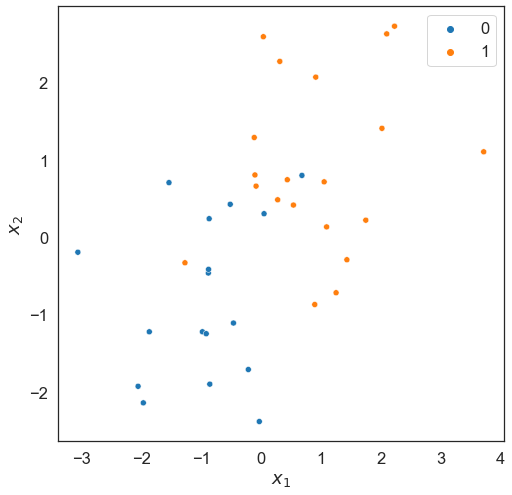

In [11]:
sns.set_style('white')
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={'lines.linewidth': 2.5})

sns.scatterplot(data=X_train, x=X_train[:, -2], y=X_train[:, -1], hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

##### **Learning the model parameters**

In [12]:
lsc = LeastSquareClassification()

1. **Normal Equation method**

In [13]:
lsc.fit(X_train, y_train_trans, reg_rate=0)

print('Weight vector:\n', lsc.w)
print('Shape of Weight vector : ',lsc.w.shape)

Weight vector:
 [[ 0.48609972  0.51390028]
 [-0.17931587  0.17931587]
 [-0.13403713  0.13403713]]
Shape of Weight vector :  (3, 2)


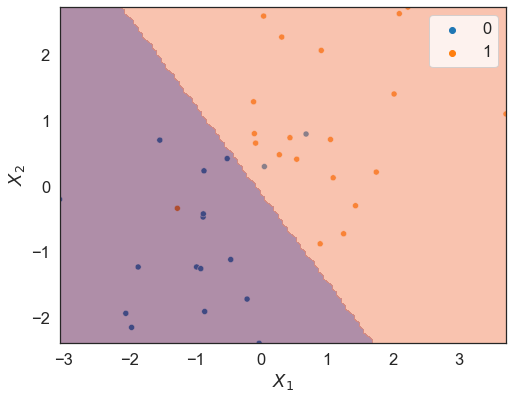

In [14]:
visualize_model(X_train, y_train, lsc)

2. **Iterative Optimization**

2. A. Gradient Descent method

In [15]:
lsc_gd = LeastSquareClassification()
lsc_gd.gd(X_train,y_train_trans, num_epochs=100, lr=1e-3,reg_rate=0)

print('Weight vector:\n', lsc_gd.w)
print('Shape of Weight vector : ',lsc_gd.w.shape)

Weight vector:
 [[ 0.4741392   0.50164545]
 [-0.17995691  0.17696853]
 [-0.13221319  0.13762446]]
Shape of Weight vector :  (3, 2)


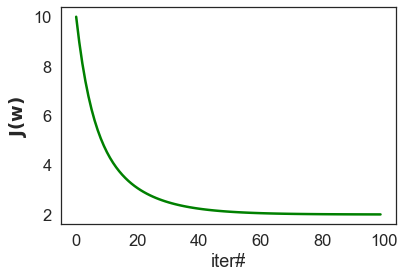

In [16]:
plot_learning_curve(lsc_gd.err_all)

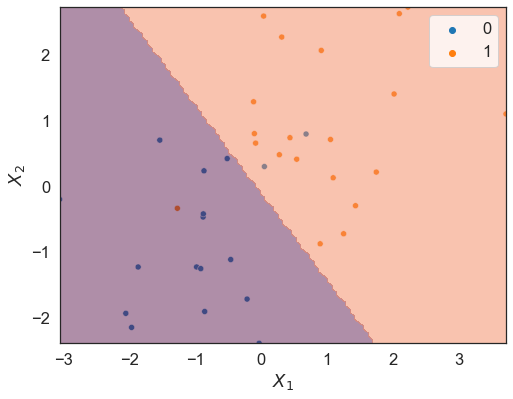

In [17]:
visualize_model(X_train, y_train, lsc_gd)

2. B. Stochastic Gradient Descent method

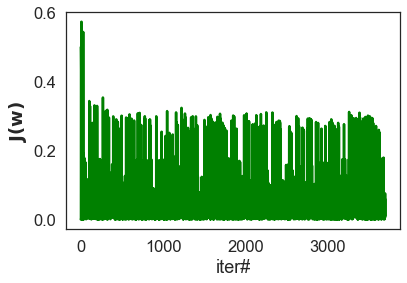

In [18]:
lsc_sgd = LeastSquareClassification()

lsc_sgd.sgd(X_train, y_train_trans, num_epochs=100, reg_rate=0)
plot_learning_curve(lsc_sgd.err_all)

##### Evaluating metrics

In [19]:
y_test_pred = lsc.predict(X_test)
print(y_test)
print(y_test_pred)

[1 1 1 0 1 0 0 0 0 0 1 0 0]
[1 1 1 0 1 0 0 0 0 0 1 0 0]


Get counts of true positive and negatives, false positives and negatives.

In [20]:
tp = np.where((y_test == 1) & (y_test_pred == 1), 1, 0).sum()
tn = np.where((y_test == 0) & (y_test_pred == 1), 0, 0).sum()
fp = np.where((y_test == 0) & (y_test_pred == 1), 1, 0).sum()
fn = np.where((y_test == 1) & (y_test_pred == 1), 0, 0).sum()


def precision(tp, fp):
    if (tp+fp) == 0:return np.nan
    return tp/(tp+fp)

def recall(tp,fn):
    if (tp+fp) == 0:return np.nan
    return tp/(tp+fn)

def accuracy(tp, fp, tn, fn):
    return (tp+tn)/(tp + tn + fp + fn)

def f1_score(pr, r):
    return 2*pr*r/(pr+r)

In [21]:
pr = precision(tp, fp)
r = recall(tp, fn)

print("Precision :", pr)
print("Recall :", r)
print("Accuracy :", accuracy(tp, fp, tn, fn))
print("F1 score :", f1_score(pr, r))


Precision : 1.0
Recall : 1.0
Accuracy : 1.0
F1 score : 1.0


#### DEMO 2: *Linear separable binary classification with outliers*

In [22]:
X_train, X_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_outliers=True)

print('Shape of training feature-matrix :', X_train.shape)
print('Shape of label-vector : ', y_train.shape)

print("\nShape of test feature-matrix :", X_test.shape)
print("Shape of test label-vector :", y_test.shape)

Shape of training feature-matrix : (41, 3)
Shape of label-vector :  (41,)

Shape of test feature-matrix : (14, 3)
Shape of test label-vector : (14,)


Visualizing the data:

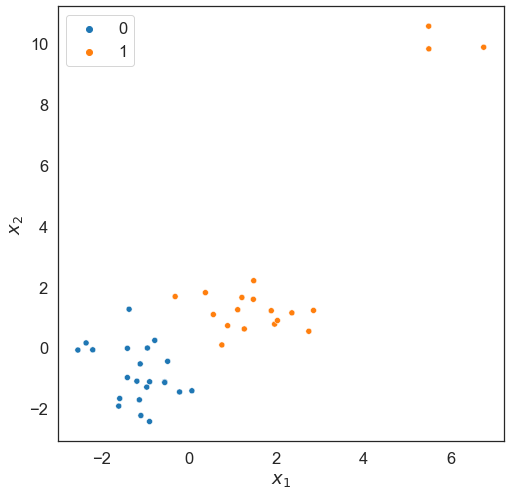

In [23]:
sns.set_style('white')
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={'lines.linewidth': 2.5})

sns.scatterplot(data=X_train, x=X_train[:, -2], y=X_train[:, -1], hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

##### **Learning the model parameters**

In [24]:
lsc_outlier = LeastSquareClassification()

1. **Normal Equation method**

In [25]:
lsc_outlier.fit(X_train, y_train_trans, reg_rate=0)
print('Weight vector:\n', lsc_outlier.w)

Weight vector:
 [[ 0.59456708  0.40543292]
 [-0.22464191  0.22464191]
 [ 0.03512816 -0.03512816]]


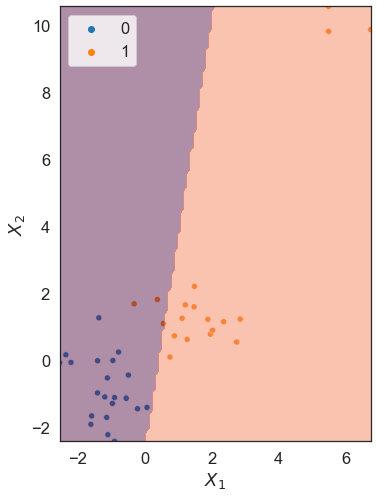

In [26]:
visualize_model(X_train, y_train, lsc_outlier)

2. **Iterative Optimization**

2. A. Gradient Descent method

In [27]:
lsc_gd_out = LeastSquareClassification()
lsc_gd_out.gd(X_train, y_train_trans, num_epochs=100, lr=1e-3, reg_rate=0)

print('Weight vector:\n', lsc_gd_out.w)


Weight vector:
 [[ 0.58373053  0.39537492]
 [-0.22460673  0.21846553]
 [ 0.03601546 -0.03012007]]


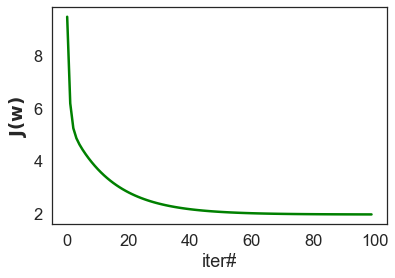

In [28]:
plot_learning_curve(lsc_gd_out.err_all)

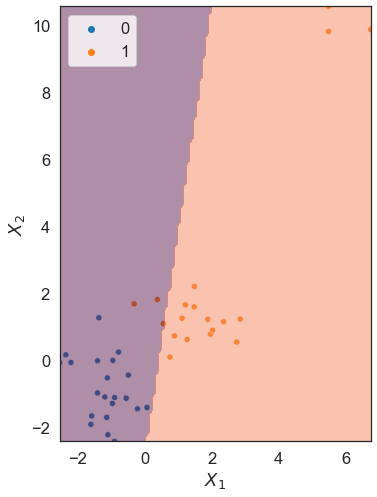

In [29]:
visualize_model(X_train, y_train, lsc_gd_out)

#### DEMO 3: *Multiclass classification (k>2)*

In [30]:
X_train, X_test, y_train, y_test, y_train_trans, y_test_trans = preprocess(add_class=True)

print('Shape of training feature-matrix:', X_train.shape)
print('Shape of label-vector', y_train.shape)

print("\nShape of test feature-matrix:", X_test.shape)
print("Shape of test label-vector:", y_test.shape)


Shape of training feature-matrix: (56, 3)
Shape of label-vector (56,)

Shape of test feature-matrix: (19, 3)
Shape of test label-vector: (19,)


Visualizing the data:

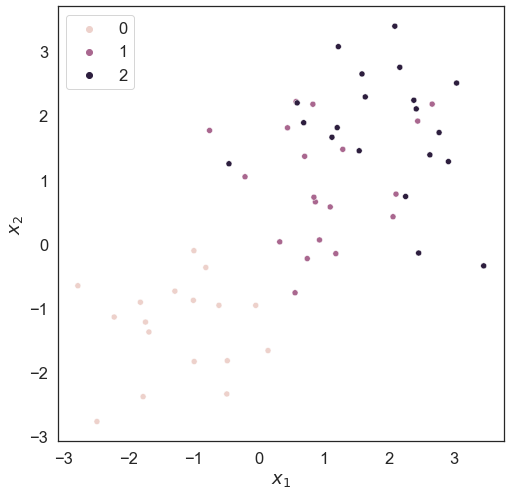

In [31]:
sns.set_style('white')
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={'lines.linewidth': 2.5})

sns.scatterplot(data=X_train, x=X_train[:, -2], y=X_train[:, -1], hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


##### **Learning the model parameters**

In [32]:
lsc_multi_class = LeastSquareClassification() 
lsc_multi_class.fit(X_train, y_train_trans , reg_rate=0)
print('Weight vector:\n', lsc_multi_class.w)

Weight vector:
 [[ 0.47326488  0.30239235  0.22434277]
 [-0.13864333  0.02443115  0.11421218]
 [-0.14391582  0.0376302   0.10628562]]


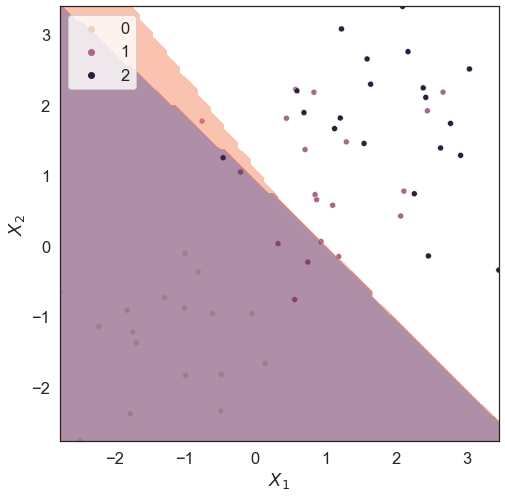

In [33]:
visualize_model(X_train, y_train, lsc_multi_class)

##### Evaluating metrics

In [34]:
from sklearn.metrics import classification_report 
y_test_pred = lsc_multi_class.predict(X_test)

print('y_test :',y_test)
print('y_pred :', y_test_pred)
print()

print(classification_report(y_test,y_test_pred, zero_division=0))

y_test : [0 1 1 2 2 0 0 0 0 2 1 1 0 2 1 1 2 0 0]
y_pred : [0 2 2 2 2 0 2 2 0 2 2 2 0 2 2 2 2 0 0]

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.00      0.00      0.00         6
           2       0.38      1.00      0.56         5

    accuracy                           0.58        19
   macro avg       0.46      0.58      0.47        19
weighted avg       0.52      0.58      0.51        19



#### DEMO 4: *Polynomial least square classification*

In this demonstration, we will generate points from two classes such that the decision boundary between them is circular (i.e. non-linear) 

In [35]:
from sklearn.datasets import make_circles
X, y = make_circles()

Transforming the feature set to obtain the polynomial features of degree 2 and then train least-squre-classification on the transformed feature set.

In [36]:
X_poly = polynomial_transform(X, degree=2)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y)

In [37]:
X[:5]

array([[-0.06279052, -0.99802673],
       [ 0.63742399,  0.77051324],
       [-0.63742399, -0.77051324],
       [ 0.42577929,  0.90482705],
       [ 0.30901699,  0.95105652]])

In [38]:
X_poly[:5]

array([[ 1.        , -0.06279052, -0.99802673,  0.00394265,  0.06266662,
         0.99605735],
       [ 1.        ,  0.63742399,  0.77051324,  0.40630934,  0.49114363,
         0.59369066],
       [ 1.        , -0.63742399, -0.77051324,  0.40630934,  0.49114363,
         0.59369066],
       [ 1.        ,  0.42577929,  0.90482705,  0.18128801,  0.38525662,
         0.81871199],
       [ 1.        ,  0.30901699,  0.95105652,  0.0954915 ,  0.29389263,
         0.9045085 ]])

In [39]:
print('Shape of feature matrix before transformation :',X.shape)
print('Shape of feature matrix after polynomial transformation of degree 2 :', X_poly.shape)


Shape of feature matrix before transformation : (100, 2)
Shape of feature matrix after polynomial transformation of degree 2 : (100, 6)


Visualizing the data:

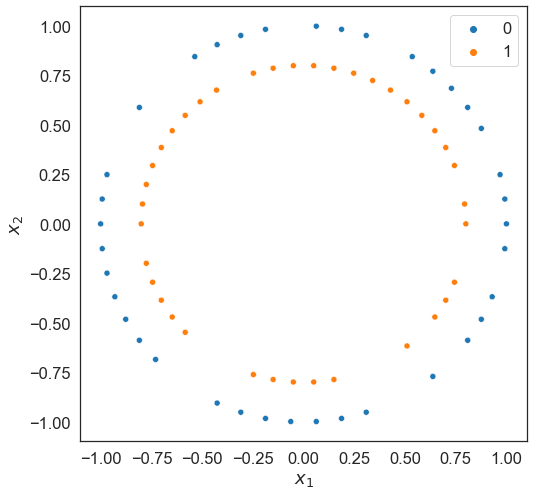

In [40]:
sns.set_style('white')
f = plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5, rc={'lines.linewidth': 2.5})

sns.scatterplot(data=X_train, x=X_train[:, 1], y=X_train[:, 2], hue=y_train)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


##### Encode labels with LabelTransformer

In [41]:
y_train_trans = LabelTransformer().encode(y_train)
y_test_trans = LabelTransformer().encode(y_test)

##### Learning the model parameters

In [42]:
lsc_poly = LeastSquareClassification()
lsc_poly.fit(X_train, y_train_trans, reg_rate=1)
print('Weight vector :\n', lsc_poly.w)

Weight vector :
 [[-0.63802792  1.49578742]
 [ 0.01709354 -0.01958776]
 [-0.03768485  0.04337986]
 [ 1.39785128 -1.23832275]
 [ 0.04365414 -0.04542709]
 [ 1.39280783 -1.23306034]]


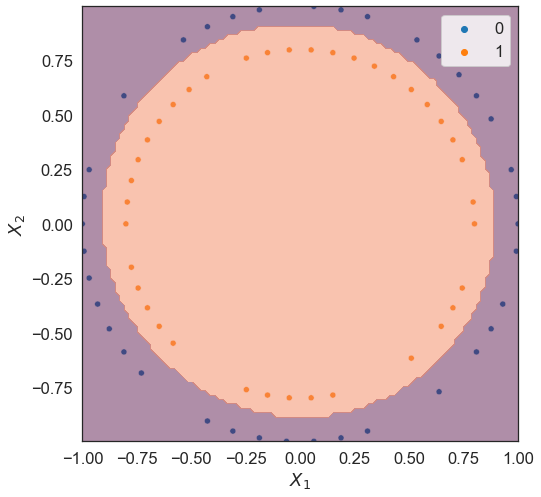

In [43]:
visualize_model(X_train, y_train, lsc_poly,degree=2)

##### Evaluating metrics

In [44]:
y_test_pred_poly = lsc_poly.predict(X_test)

print('y_test :',y_test)
print('y_pred :', y_test_pred_poly)
print()

print(classification_report(y_test,y_test_pred_poly, zero_division=0))

y_test : [0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1]
y_pred : [0 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

